## Some instructions for running the code

1. Rename options folder to optionss
2. Rename options.py file in optionss folder as optionsss.py
3. Rename test.py as testing.py
4. Edit the 24th line in testing.py appropriately
5. Comment out the 18th line and 46th line from the setup.sh file.


In [ ]:
! git clone https://github.com/andreas128/SRFlow.git

Cloning into 'SRFlow'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 160 (delta 41), reused 18 (delta 18), pack-reused 96
Receiving objects: 100% (160/160), 892.42 KiB | 6.51 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [ ]:
!pip install opencv-python
!pip install scikit-image
!pip install scipy
!pip install torch torchvision torchaudio
!pip install matplotlib
!pip install cffi numpy pandas PyWavelets

# Apply a trained SRFlow model

In [ ]:
!apt install python3.10-venv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-pip-whl python3-setuptools-whl
The following NEW packages will be installed:
  python3-pip-whl python3-setuptools-whl python3.10-venv
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 2,473 kB of archives.
After this operation, 2,882 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-pip-whl all 22.0.2+dfsg-1ubuntu0.3 [1,679 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-setuptools-whl all 59.6.0-1.2ubuntu0.22.04.1 [788 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3.10-venv amd64 3.10.12-1~22.04.2 [5,724 B]
Fetched 2,473 kB in 1s (4,469 kB/s)
Selecting previously unselected package python3-pip-whl.
(Reading database ... 120831 files and directories currently installed.)
Pr

In [ ]:
!cd SRFlow && ./setup.sh


########################################
Setup Virtual Environment
########################################

/content/SRFlow/myenv/bin/python

########################################
Download models, data
########################################

--2023-08-28 14:43:17--  http://data.vision.ee.ethz.ch/alugmayr/SRFlow/datasets.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/alugmayr/SRFlow/datasets.zip [following]
--2023-08-28 14:43:17--  https://data.vision.ee.ethz.ch/alugmayr/SRFlow/datasets.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11465531355 (11G) [application/zip]
Saving to: ‘datasets.zip’

datasets.zip        100%[===============

In [ ]:
# ! ./run_jupyter.sh

## Reproduce using our Setup

- Use the ./setup.sh
- It install the all packages from the requirements.txt
- If this notebook does not work, copy the code to start it from setup.py
- The python interpreter should be '../myenv/bin/python3'

In [ ]:
# import sys
# print(sys.executable)

/Users/andreaslugmayr/miniconda3/envs/srf2/bin/python


# Initialize

In [ ]:
!pip install lpips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.0 MB/s eta 0:00:00


In [ ]:
import os
print(os.getcwd())
os.chdir("/content/SRFlow/code")
print(os.getcwd())


/content/SRFlow/code
/content/SRFlow/code


In [ ]:
import natsort, glob, pickle, torch
from collections import OrderedDict
import numpy as np
import os

# import options.options as option
from models import create_model
from imresize import imresize

import Measure

def find_files(wildcard): return natsort.natsorted(glob.glob(wildcard, recursive=True))

from PIL import Image
def imshow(array):
    display(Image.fromarray(array))


In [ ]:
import utils

In [ ]:
# from utils.test import load_model, fiFindByWildcard, imread

def pickleRead(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [ ]:
# Convert to tensor
def t(array): return torch.Tensor(np.expand_dims(array.transpose([2, 0, 1]), axis=0).astype(np.float32)) / 255

# convert to image
def rgb(t): return (np.clip((t[0] if len(t.shape) == 4 else t).detach().cpu().numpy().transpose([1, 2, 0]), 0, 1) * 255).astype(np.uint8)

# List model files

If you do not see models here, download them as in `setup.sh`.

In [ ]:
find_files("../pretrained_models/*.pth")

['../pretrained_models/ESRGAN_DF2K_8X.pth',
 '../pretrained_models/RRDB_CelebA_8X.pth',
 '../pretrained_models/RRDB_DF2K_4X.pth',
 '../pretrained_models/RRDB_DF2K_8X.pth',
 '../pretrained_models/SRFlow_CelebA_8X.pth',
 '../pretrained_models/SRFlow_DF2K_4X.pth',
 '../pretrained_models/SRFlow_DF2K_8X.pth']

# Configuration files


In [ ]:
find_files("confs/*.yml")

['confs/RRDB_CelebA_8X.yml',
 'confs/RRDB_DF2K_4X.yml',
 'confs/RRDB_DF2K_8X.yml',
 'confs/SRFlow_CelebA_8X.yml',
 'confs/SRFlow_DF2K_4X.yml',
 'confs/SRFlow_DF2K_8X.yml']

# List dataset directories


In [ ]:
find_files("../datasets/**/")

['../datasets/',
 '../datasets/celebA-validation-gt/',
 '../datasets/celebA-validation-x8/',
 '../datasets/div2k-validation-modcrop8-gt/',
 '../datasets/div2k-validation-modcrop8-x4/',
 '../datasets/div2k-validation-modcrop8-x8/']

In [ ]:
conf_path = './confs/SRFlow_CelebA_8X.yml'

### Instancieate the Model

In [ ]:
from testing import load_model, fiFindByWildcard, imread

In [ ]:
from optionss import optionsss

In [ ]:
help(optionsss)

Help on module optionss.optionsss in optionss:

NAME
    optionss.optionsss

DESCRIPTION
    # Copyright (c) 2020 Huawei Technologies Co., Ltd.
    # Licensed under CC BY-NC-SA 4.0 (Attribution-NonCommercial-ShareAlike 4.0 International) (the "License");
    # you may not use this file except in compliance with the License.
    # You may obtain a copy of the License at
    #
    #     https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode
    #
    # The code is released for academic research use only. For commercial use, please contact Huawei Technologies Co., Ltd.
    # Unless required by applicable law or agreed to in writing, software
    # distributed under the License is distributed on an "AS IS" BASIS,
    # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    # See the License for the specific language governing permissions and
    # limitations under the License.
    #
    # This file contains content licensed by https://github.com/xinntao/BasicSR/

In [ ]:
model, opt = load_model(conf_path)

OrderedDict([('manual_seed', 10), ('lr_G', 0.0005), ('weight_decay_G', 0), ('beta1', 0.9), ('beta2', 0.99), ('lr_scheme', 'MultiStepLR'), ('warmup_iter', -1), ('lr_steps_rel', [0.5, 0.75, 0.9, 0.95]), ('lr_gamma', 0.5), ('niter', 200000), ('val_freq', 40000), ('lr_steps', [100000, 150000, 180000, 190000])])


### Find the png paths

In [ ]:
lq_paths = fiFindByWildcard(os.path.join(opt['dataroot_LR'], '*.png'))
gt_paths = fiFindByWildcard(os.path.join(opt['dataroot_GT'], '*.png'))
print(lq_paths, gt_paths) # For CelebA we have just 1

['../datasets/celebA-validation-x8/example0.png'] ['../datasets/celebA-validation-gt/example0.png']


In [ ]:
lqs = [imread(p) for p in lq_paths]
gts = [imread(p) for p in gt_paths]


First LR image


First HR image


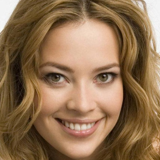

In [ ]:
print("First LR image")
imshow(lqs[0])

print("First HR image")
imshow(gts[0])

# Super-Resolve using SRFlow for multiple temperatures

In [ ]:
measure = Measure.Measure()


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 206MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


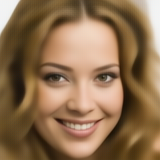

/content/SRFlow/code/Measure.py:48: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  score, diff = ssim(imgA, imgB, full=True, multichannel=True)


Temperature: 0.00 - PSNR: 26.4, SSIM: 0.8, LPIPS: 0.24




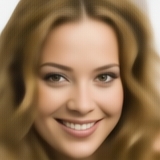

Temperature: 0.10 - PSNR: 26.3, SSIM: 0.8, LPIPS: 0.23




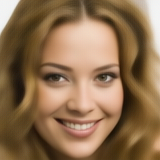

Temperature: 0.20 - PSNR: 26.3, SSIM: 0.7, LPIPS: 0.21




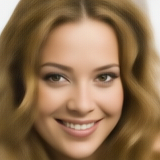

Temperature: 0.30 - PSNR: 26.2, SSIM: 0.7, LPIPS: 0.18




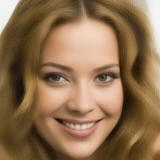

Temperature: 0.40 - PSNR: 26.0, SSIM: 0.7, LPIPS: 0.16




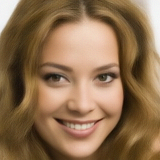

Temperature: 0.50 - PSNR: 25.8, SSIM: 0.7, LPIPS: 0.12




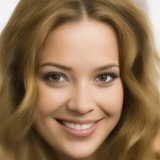

Temperature: 0.60 - PSNR: 25.6, SSIM: 0.7, LPIPS: 0.12




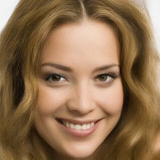

Temperature: 0.70 - PSNR: 25.2, SSIM: 0.7, LPIPS: 0.09




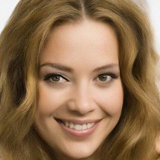

Temperature: 0.80 - PSNR: 24.9, SSIM: 0.7, LPIPS: 0.09




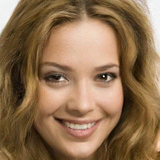

Temperature: 0.90 - PSNR: 24.0, SSIM: 0.6, LPIPS: 0.08




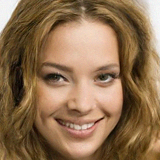

Temperature: 1.00 - PSNR: 23.8, SSIM: 0.6, LPIPS: 0.08




In [ ]:
lq = lqs[0]
gt = gts[0]

for temperature in np.linspace(0, 1, num=11):
    # Sample a super-resolution for a low-resolution image
    sr = rgb(model.get_sr(lq=t(lq), heat=temperature))
    imshow(sr)
    psnr, ssim, lpips = measure.measure(sr, gt)
    print('Temperature: {:0.2f} - PSNR: {:0.1f}, SSIM: {:0.1f}, LPIPS: {:0.2f}\n\n'.format(temperature, psnr, ssim, lpips))


# LR Consistency

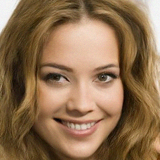

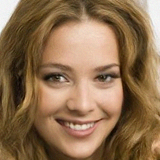

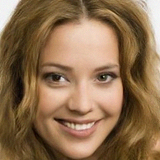

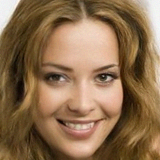

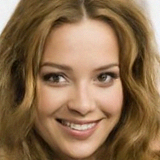

In [ ]:
lq = lqs[0]
gt = gts[0]

temperature = 0.9

downsampled = lq
for idx in range(5):
    sr = rgb(model.get_sr(lq=t(downsampled), heat=temperature))
    downsampled = imresize(sr, 1/8)

    imshow(sr)
